In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import sample, seed
from astropy.io import ascii, fits
import astropy.units as u
from glob import glob
from usefulFuncs import ifind_tpfs
from LCFeatureExtraction import error_estimate, amplitude_estimate
from lightkurve import MPLSTYLE
from lightkurve import open as open_lc
# from k2spin import prot

## Light Curve Quality Indicator: Sigma estimate


### Intro

In this notebook I originally wanted to test how the my amplitude estimate compares to noise estimate in indicating the quality of a light curve. However, I am afraid my amplitude estimate is not as sophisticated as my error estimate and is sensitive to a systematic trend. Therefore I will only proceed to assess whether my error estimate is a good quality indicator for my light curves. I will focus on light curves that have some sort of periodic signal (regardless of trends).


### Target Selection
In order to make this whole process more efficient I am only selecting light curves that have a clear periodic signal.
These light curves were handpicked, and put into three groups; **low**, **high**, and **mixed** frequency oscillations; where mixed means there is more than one dominant signal in the light curve. For each group I handpicked a "large" sample by skimming through the light curves collection (from this cluster), they all are in the folder `LightCurvesPlots`. 

For the test in this notebook I simply combined all these handpicked light curves, and grabed a random sample of N_targets.

### Noise Calculation
The noise calculation is better discussed in the LCFeatureExploration notebook.
It simply is a Median Absolute Error of the light curve and a smoothed out version (Gaussian).
It is worth to note that the error estimates are target-specific; they cannot be compared across targets. However, they do not need to in order to automate the aperture-method selection on a per-target basis.

### Assessing Light Curve Quality 
In order to visually assess the quality of the light curve I am creating a grid of plots to look at all aperture methods at once, for each target.
Every light curve is normalized, sigma clipped, and plotted along with the error estimate. In order to assess whether the metric was successful I assess each target indepdently, and look at the overall success across all targets. For each target I first find the light curve with lowest noise value and compare it to the other two light curves. If the selected light curve has a visually detectable periodic signal and seems to have the least number of artifacts, then I claim it as successful. Such artifacts include trends, and noise that may impact the power spectral density.

### Discussion

Overally I think the noise metric is a decent quality indicator. It seems to also be sensible to trends, or maybe it is just that those light curves with trends also have a larger noise. As expected, the noise metric is not useful when determining the quality of the strength of the signal. In other words, I can't use it to determine which light curve has the larger amplitudes. This is clear for targets 93549226 & 93014257: while the light curves with lowest noise are good, there are other light curves that can yield a higher power for the intrinsic signal. Using the metric can still help us increase our confidence in our detected period estimates, and 

In [2]:
# Parameters
outlier_sigma = 3.0
N_targets = 15
seed(12345)

# Get quality mask
with fits.open('DataInput/ClusterQuality/Sector8_Sample.fits.gz') as quality_sample:
    # For Chelsea's quality flags:
    #   0 means good, 1 means bad
    quality_flags = quality_sample[1].data['quality']
    good_mask = ~quality_flags.astype(bool)
    
colors = ['k' if flag else 'red' for flag in good_mask]

# Get filepaths to LightCurve FITS
src_lcfs = 'LightCurvesFITS/*.fits'
fits_paths = glob(src_lcfs)

# Pool of hand picked targets with at least one light curve whose frequeancy appers to be high/low or mixed
high_IDs = ['92580385', '92581404', '93265597', '93022865', '93551193', '93630147', '93831298', '93912230', '144996772', '144997798']
mix_IDs = ['93550865', '93270923', '94185042', '144759493']
low_IDs = ['92475268', '92583560', '93013696', '93014257', '93016484', '93016484', '93269120', '93549309', '94107183', '14475228']

all_freq_ids = high_IDs + mix_IDs + low_IDs
sample_freq_ids = sample(all_freq_ids, N_targets)

### Plot Grid Description
Here is the plot grid for assessment. The light curves to be assessed are selected above, and in order to use different light curves one must change the random seed. The grid has a size of N_targets by 3 (aperture-methods). The order of the columns starting from the left: Handpicked aperture, Percentile Ap, Threshold Ap.

/Users/joseperez/miniconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:667: LightkurveWarning: The light curve has a negative median flux (-6.44e+01); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)
/Users/joseperez/miniconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:667: LightkurveWarning: The light curve has a negative median flux (-4.64e+01); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)


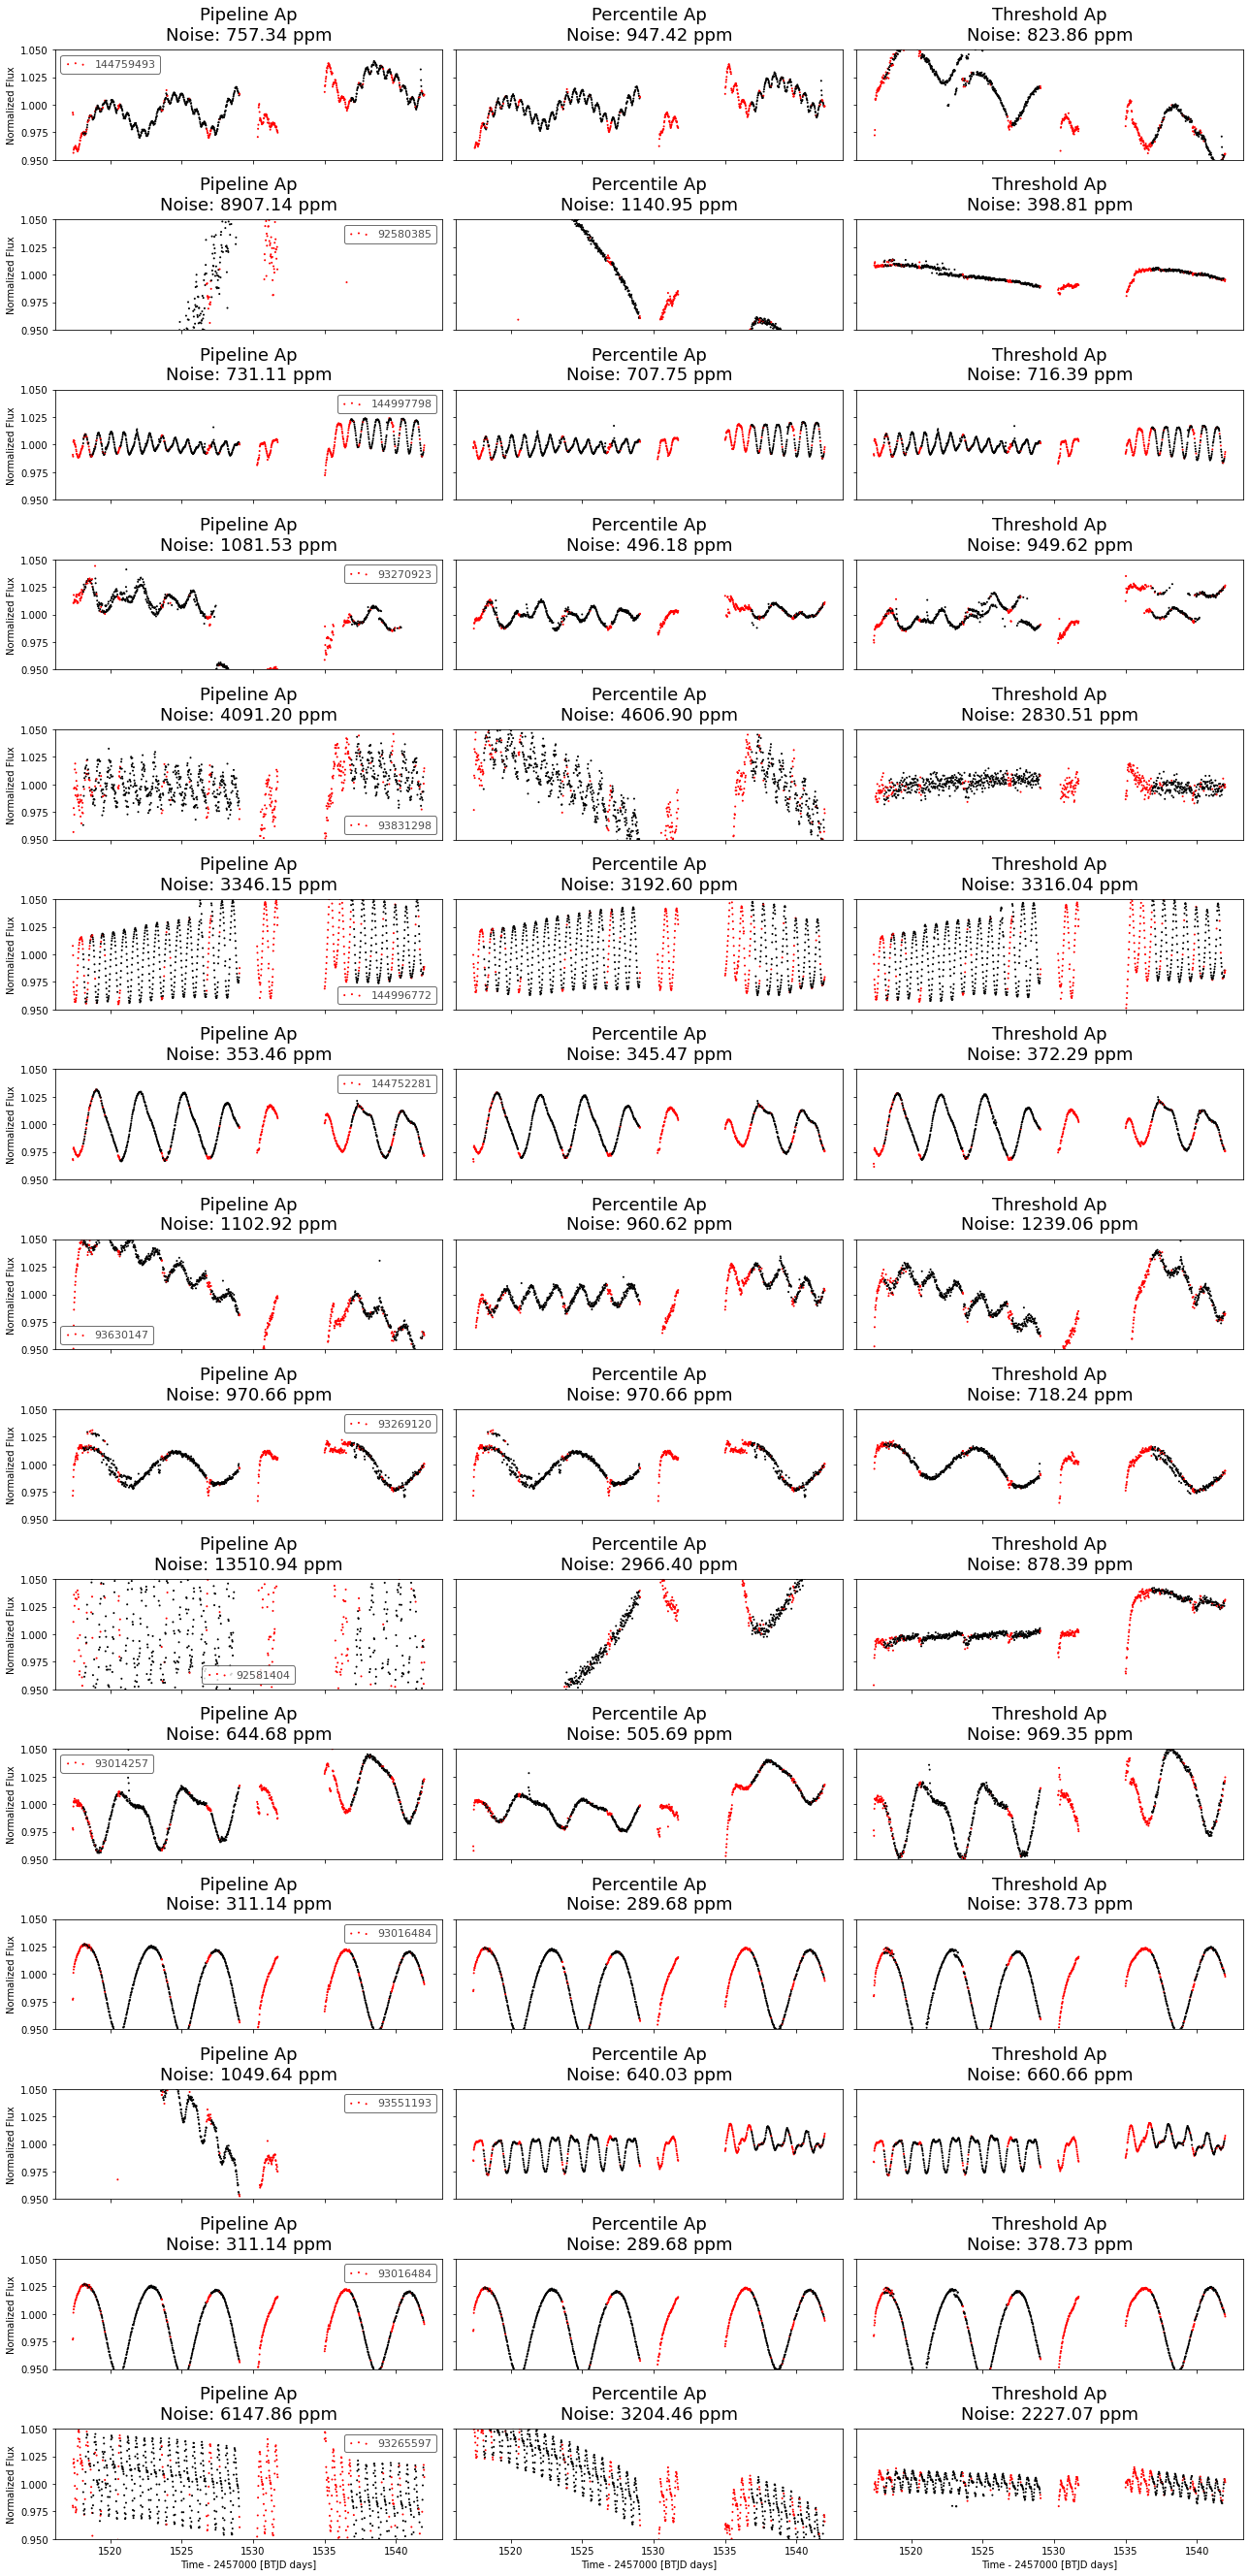

In [3]:
fig, axes = plt.subplots(N_targets, 3, figsize=(18, 2.5*N_targets // 1), sharey='row', sharex='all')
titles = 'Pipeline Ap', 'Percentile Ap', 'Threshold Ap'
for i, ticid in enumerate(sample_freq_ids):
    # Get the light curves associated with this TICID
    # By sorting them, I get: Handpicked Ap, Percentile Ap, Threshold Ap
    lc_paths = sorted([fits_path for fits_path in fits_paths if ticid in fits_path])

    for j, lc_path in enumerate(lc_paths):
        # Import Light Curve, Sigma Clip, and Scatter
        lc = open_lc(lc_path).get_lightcurve('FLUX')
        if lc._flux_unit.is_equivalent(u.dimensionless_unscaled):
            clipped_lc, clipped_mask = lc.remove_outliers(sigma=outlier_sigma, return_mask=True)
        else:
            clipped_lc, clipped_mask = lc.normalize().remove_outliers(sigma=outlier_sigma, return_mask=True)
            
        if axes[i, j].is_first_col():
            clipped_lc.scatter(ax=axes[i, j], c=[c for c, b in [*zip(colors, ~clipped_mask)] if b], show_colorbar=False)
        else:
            clipped_lc.scatter(ax=axes[i, j], c=[c for c, b in [*zip(colors, ~clipped_mask)] if b], show_colorbar=False, label='')
        
        # Estimate Features
        sigma = error_estimate(clipped_lc, quality=good_mask[~clipped_mask])
        # amplitude = amplitude_estimate(clipped_lc, quality=good_mask[~clipped_mask]) / sigma
        
        # Workout plot details
        with plt.style.context(MPLSTYLE):
            # axes[i, j].set_title(f'{titles[j]}\nSNR: {amplitude:.2f}  Noise: {sigma*1e6:.2f}')
            axes[i, j].set_title(f'{titles[j]}\nNoise: {sigma*1e6:.2f} ppm')
        if not axes[i, j].is_first_col():
            axes[i, j].set_ylabel('')
        if not axes[i, j].is_last_row():
            axes[i, j].set_xlabel('')

        # if clipped_lc.flux.max() > 1.1:
        axes[i, j].set_ylim(0.95, 1.05)
            

# Tighten plot to look better
plt.tight_layout()